In [1]:
import numpy as np
import os,sys
import math
from sklearn.cluster import KMeans
import scipy.stats as sp
import uproot
import warnings


#--------------------------------------------------------------------------------------------------------------------------------------------

def getData(fname="", procName="Events"):
    file = uproot.open(fname)
    dq_dict = file[procName].arrays(library="np")
    dq_events = {
        "Hits":{
            "detID": dq_dict["hit_detID"],
            "edep": dq_dict["hit_edep"],
            "elmID": dq_dict["hit_elmID"],
            "hit_pos": dq_dict["hit_pos"]
        },
        "track":{
            "x": dq_dict["track_x_CAL"],
            "y": dq_dict["track_y_CAL"],
            "ID": dq_dict["eventID"],
            "pz": dq_dict["track_pz_st1"]
        },
        "st23": {
            "ntrack23": dq_dict["n_st23tracklets"],
            "px":   dq_dict["st23tracklet_px_st3"],
            "py":   dq_dict["st23tracklet_py_st3"],
            "pz":   dq_dict["st23tracklet_pz_st3"],
            "x":   dq_dict["st23tracklet_x_st3"],
            "y":   dq_dict["st23tracklet_y_st3"],
            "z":   dq_dict["st23tracklet_z_st3"],
            "Cal_x": dq_dict["st23tracklet_x_CAL"],
            "Cal_y": dq_dict["st23tracklet_y_CAL"]
        }
    }

    return dq_events
#--------------------------------------------------------------------------------------------------------------------------------------------

ntowersx=72
ntowersy=36
sizex=5.53 # in cm
sizey=5.53 # in cm
ecalx=[-200,200] #size in cm
ecaly=[-100,100]
binsx=ecalx[1]- ecalx[0]
binsy=ecaly[1]- ecaly[0]
sfc = 0.1146337964120158 #sampling fraction of emcal
emin=0.0005

#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_bytuple(dq_events):
    dq_hits = dq_events["Hits"]
    x_pos = []
    y_pos = []
    eve_energy = []
    for i in range(len(dq_events["Hits"]["edep"])):
        output = emcal_byevent(dq_hits, i)
        if len(output[0]) != 0:
            x_pos.append(output[0])
            y_pos.append(output[1])
            eve_energy.append(output[2])
        else:
            x_pos.append(np.array([]))
            y_pos.append(np.array([]))
            eve_energy.append(np.array([]))
            
    return x_pos, y_pos, eve_energy

#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_byevent(dq_hits, evtNum):
    raw_elmID = dq_hits["elmID"][evtNum]
    raw_edep = dq_hits["edep"][evtNum]
    
    emcal_mask = dq_hits["detID"][evtNum] == 100
    eng_mask = raw_edep[emcal_mask] >= emin
    
    elmID = raw_elmID[emcal_mask][eng_mask]#could also use dstack here to zip (elmID and edep)
    edep = raw_edep[emcal_mask][eng_mask]
    
    emcal_towerx = elmID // ntowersy
    emcal_towery = elmID % ntowersy
    emcal_x = ecalx[0] + emcal_towerx * sizex
    emcal_y = ecaly[0] + emcal_towery * sizey
    emcal_edep = edep / sfc
    
    return emcal_x, emcal_y, emcal_edep

#--------------------------------------------------------------------------------------------------------------------------------------------

def find_energy_seeds(x, y, energy, min_energy=0.2, seed_radius=30):
    high_energy_mask =energy >min_energy
    high_energy_points = np.column_stack((x[high_energy_mask], y[high_energy_mask], energy[high_energy_mask]))
    seeds = []
    indices = []
    for i, (x_val, y_val, energy_val) in enumerate(high_energy_points):
        distances = np.array(np.sqrt((high_energy_points[:, 0] - x_val)**2 + (high_energy_points[:, 1] - y_val)**2))
        distances[i] = seed_radius + 1
        points_within_radius_mask = distances < seed_radius
        points_within_radius = high_energy_points[points_within_radius_mask]
        if len(points_within_radius) == 0 or energy_val > np.max(points_within_radius[:, 2], initial=0):
            seeds.append([x_val, y_val])
            indices.append(np.where(high_energy_mask)[0][i])
            
    return np.array(seeds), indices
    
#--------------------------------------------------------------------------------------------------------------------------------------------
def multi_clusters(dq_events):
    (x, y, eng)=emcal_bytuple(dq_events)
    labels=[]
    seeds=[]
    labels_decrease=[]
    seed_labels = []
    kmeans_ctr = []
    for i in range(len(eng)):
        (seed, index)=find_energy_seeds(x[i], y[i], eng[i])
        seeds.append(seed)
        points=np.column_stack((x[i],y[i]))
        try:
            warnings.simplefilter("ignore")
            kmeans = KMeans(n_clusters=len(seed), init=seed , random_state=0, max_iter=1).fit(points)#since center given to grow, n_init==1
            labels.append(kmeans.labels_)
            label_decr = label_clus_eng(kmeans.labels_, eng[i])
            labels_decrease.append(label_decr)
            seed_labels.append(kmeans.labels_[index])
        except:
            labels.append([])
            labels_decrease.append([])
            seed_labels.append([])
    return x, y, eng, labels, labels_decrease, seeds, seed_labels
#--------------------------------------------------------------------------------------------------------------------------------------------

def label_clus_eng(label, eng_eve):#return sorted labels by decreasing order of energy
    unique_labels = np.unique(label)
    cluster_energy = np.zeros(len(unique_labels), dtype=np.int64)
    for i in range(len(label)):
        cluster_energy[label[i]] += eng_eve[i]
    sorted_labels = unique_labels[np.argsort(cluster_energy)[::-1]]
    return sorted_labels

#--------------------------------------------------------------------------------------------------------------------------------------------

def h4_bytuple(dq_events):
    dq_hits = dq_events["Hits"]
    hits = np.squeeze(np.dstack((dq_hits["detID"], dq_hits["hit_pos"])), axis=0)

    h4x = []
    h4y = []

    for index, item in enumerate(hits):
        h4y_mask = (41 <= item[0]) & (item[0] <= 44)
        h4x_mask = (45 <= item[0]) & (item[0] <= 46)
        ID_pos = np.squeeze(np.dstack((hits[index][0],hits[index][1])), axis=0)
        h4x.append(ID_pos[h4x_mask])
        h4y.append(ID_pos[h4y_mask])
    return h4x, h4y

#--------------------------------------------------------------------------------------------------------------------------------------------
def gen_wew(x_eve, y_eve, eng_eve):
    eng_tot = np.sum(eng_eve)
    x_bar = np.dot(x_eve, eng_eve) / eng_tot
    y_bar = np.dot(y_eve, eng_eve) / eng_tot

    x_sq_eve = eng_eve * (x_eve - x_bar) ** 2
    y_sq_eve = eng_eve * (y_eve - y_bar) ** 2

    try:
        wew_x = np.sqrt(np.sum(x_sq_eve) / eng_tot)
    except ZeroDivisionError:
        wew_x = -1

    try:
        wew_y = np.sqrt(np.sum(y_sq_eve) / eng_tot)
    except ZeroDivisionError:
        wew_y = -1

    return [wew_x, wew_y]
#--------------------------------------------------------------------------------------------------------------------------------------------
def gen_wid(x_eve, y_eve):
    x_bar = np.mean(x_eve)
    y_bar = np.mean(y_eve)

    x_sq_eve = (x_eve - x_bar) ** 2
    y_sq_eve = (y_eve - y_bar) ** 2

    try:
        wid_x = np.sqrt(np.mean(x_sq_eve))
    except ZeroDivisionError:
        wid_x = -1

    try:
        wid_y = np.sqrt(np.mean(y_sq_eve))
    except ZeroDivisionError:
        wid_y = -1

    return [wid_x, wid_y]
#--------------------------------------------------------------------------------------------------------------------------------------------

def extend_track(trkl_coord):
    y_z = np.array([2130.27, 2146.45, 2200.44, 2216.62])
    x_z = np.array([2251.71, 2234.29])
    transpose_coord = np.array(trkl_coord).T

    # Calculate the common term for h4x and h4y
    common_term = (transpose_coord[4] / transpose_coord[5])[:, np.newaxis]

    h4x = transpose_coord[1][:, np.newaxis] + common_term * (x_z - transpose_coord[2][:, np.newaxis])
    h4y = transpose_coord[1][:, np.newaxis] + common_term * (y_z - transpose_coord[2][:, np.newaxis])
    
    return h4x, h4y

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------







In [69]:
#this function is gaining data for training
file1='/Users/wongdowling/Desktop/n-tuples/5_80_training/electron_520_p580.root'
file2='/Users/wongdowling/Desktop/n-tuples/aprime_yongbin/Aee_test_eps9.root'
file3='/Users/wongdowling/Desktop/DQ_Dowling/ntuple_1000/muon_520_1000eve.root'
file4='/Users/wongdowling/Desktop/n-tuples/aprime_cmantill/Amm_1.85_56_1000.root'
file5='/Users/wongdowling/Desktop/n-tuples/5_80_training/muon_520_p580.root'
file6='/Users/wongdowling/Desktop/n-tuples/5_80_training/pi+_520_p580.root'
file7='/Users/wongdowling/Desktop/n-tuples/5_80_training/pi-_520_p580.root'
file8='/Users/wongdowling/Desktop/n-tuples/5_80_training/pi0_520_p580.root'
file9='/Users/wongdowling/Desktop/n-tuples/5_80_training/klong_520_p580.root'
file10='/Users/wongdowling/Desktop/n-tuples/5_80_training/photon_520_p580.root'
file11='/Users/wongdowling/Desktop/n-tuples/5_80_training/positron_520_p580.root'





In [84]:
dq_events = getData(file9, "Events")

(h4x, h4y) = h4_bytuple(dq_events)
dq_st23 = dq_events["st23"]
st23_trkl = np.stack((dq_st23["x"], dq_st23["y"], dq_st23["z"], dq_st23["px"], dq_st23["py"], dq_st23["pz"]), axis=1)

amm, muon, pi+. pi- has many evts doesn't have h4, while pi+ has almost 1 for each. pi0 has not h4

In [79]:
import numpy as np

def count_duplicates_in_2D_slice(slice_2D):
    unique_rows, counts = np.unique(slice_2D, axis=0, return_counts=True)
    duplicated_elements = sum(count for count in counts if count > 1)
    return duplicated_elements

def count_duplicates_in_3D_array(arr_3D):
    total_hits = 0
    total_duplicates = 0
    
    for slice_2D in arr_3D:
        total_hits += slice_2D.shape[0]
        total_duplicates += count_duplicates_in_2D_slice(slice_2D)
    
    return total_hits, total_duplicates

# Example usage:
arr_3D = h4y

total_hits, total_duplicates = count_duplicates_in_3D_array(arr_3D)
print(f"Total hits: {total_hits}")
print(f"Total duplicates: {total_duplicates}")


Total hits: 7
Total duplicates: 2


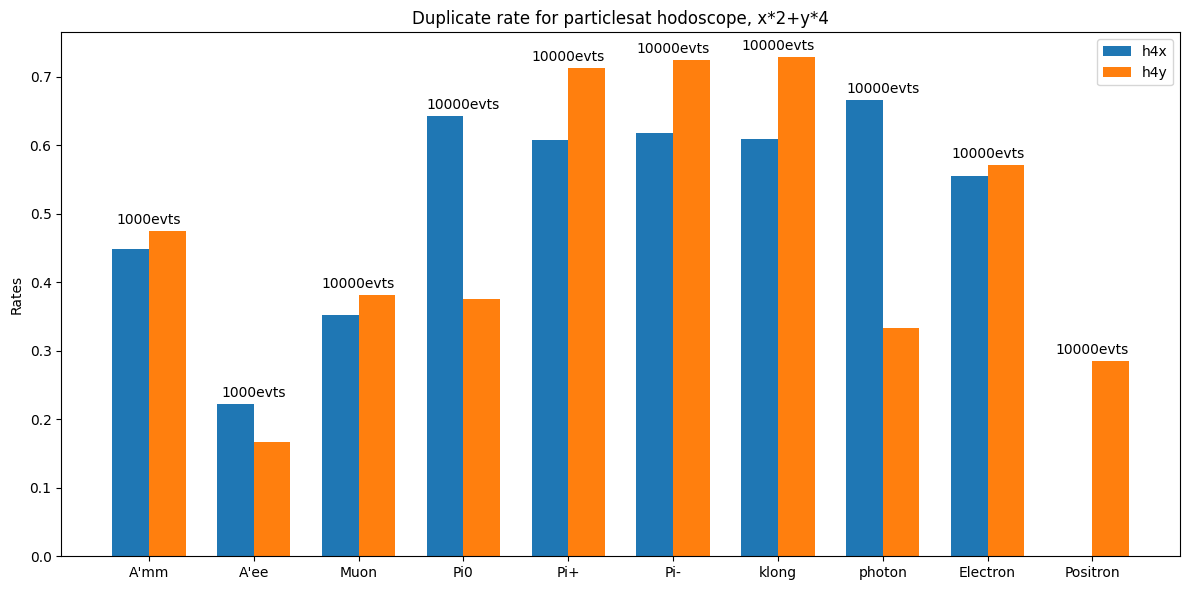

In [82]:
import matplotlib.pyplot as plt

# Sample data
data = [
    (892/1987, 2964/6244),
    (2/9, 2/12),
    (6061/17238, 20289/53159),
    (9/14, 12/32),
    (15595/25675, 55359/77691),
    (17343/28047, 63681/87827),
    (20151/33068, 75056/103036),
    (2/3, 2/6),
    (5/9, 4/7),
    (0/1, 2/7)
    
]

# Total number of coordinates for each set
totals = [1000, 1000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]

x_values = [x for x, y in data]
y_values = [y for x, y in data]

# Set bar width
bar_width = 0.35

# Create an index for the data sets
index = range(len(data))

fig, ax = plt.subplots(figsize=(12, 6))


# Bars for x values
bars1 = ax.bar(index, x_values, bar_width, label='h4x')

# Bars for y values
# We shift the index by bar_width to display the bars side by side
bars2 = ax.bar([i + bar_width for i in index], y_values, bar_width, label='h4y')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rates')
ax.set_title('Duplicate rate for particlesat hodoscope, x*2+y*4')
ax.set_xticks([i + bar_width/2 for i in index])  # Adjusting the position of x-axis labels to center them between the two bars
ax.set_xticklabels(['A\'mm', 'A\'ee', 'Muon', 'Pi0', 'Pi+', 'Pi-', 'klong', 'photon', 'Electron', 'Positron'])
ax.legend()

# Adding total number of coordinates above the bars
for i, total in enumerate(totals):
    ax.text(i + bar_width/2, max(x_values[i], y_values[i])+0.01 , f"{total}evts", ha='center')

plt.tight_layout()
plt.show()


In [85]:
h4x

[array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([[  45.        ,  -28.76876831],
        [  45.        , -144.74876404]]),
 array([[  46.        , -145.47532654]]),
 array([], shape=(0, 2), dtype=float64),
 array([[  45.        ,   48.55123138],
        [  45.        ,   48.55123138],
        [  46.        ,  105.81466675],
        [  46.        , -145.47532654]]),
 array([[  45.        ,   29.22123146],
        [  45.        ,   29.22123146],
        [  45.        ,  -48.09877014],
        [  45.        ,  -28.76876831],
        [  45.        ,  -48.09877014],
        [  45.        ,  -67.42877197],
        [  45.        ,  -28.76876831],
        [  45.        ,  -28.76876831],
        [  45.        , -144.74876404],
        [  45.        ,   67.88123322],
        [  45.        ,  -28.76876831],
        [  45.        ,    9.89123154],
        [  45.        ,   87.21123505],
        [  45.        , -144.74876404],
        [  45.        ,  -67.42